In [1]:
import xml.etree.ElementTree as ET
tree = ET.parse('Wikipedia-20161003174511.xml')
root = tree.getroot()
text_nodes = root.findall("./{http://www.mediawiki.org/xml/export-0.10/}page/{http://www.mediawiki.org/xml/export-0.10/}revision/{http://www.mediawiki.org/xml/export-0.10/}text")

The following functions are mainly for cleaning data that is being parsed in the main body of the program

In [2]:
import re

def molar_mass_unit_cleanup(molar_mass_units):
    molar_mass_units = molar_mass_units.lower()
    if (molar_mass_units[0] == 'g') & (molar_mass_units[2:5] == 'mol'):
        #'g.mol<sup>−1</sup>'
        #'g·mol<sup>−1</sup>'
        #'g/mol<ref'
        #g/mol<sup>1</sup>
        #g/moL
        return 'g/mol'
    elif (molar_mass_units == 'g') | (molar_mass_units == 'grams'):
        return 'g/mol'

def property_cleanup(line):
    line = general_tag_cleanup(line)
    return line

def formula_tag_cleanup(formula):
    #remove sub tags
    formula = re.sub('<sub>', '', formula)
    formula = re.sub('</sub>', '', formula)
    formula = re.sub('<sup>.*?</sup>', '', formula) # remove sup tags and charge info
    formula = re.sub('<nowiki>&middot;</nowiki>', '•', formula)
    return formula

def formula_bracket_cleanup(formula):
    if formula.startswith('[['):
        formula = re.sub('\[\[.*?\|', '', formula)
        formula = re.sub(']]', '', formula)
    elif formula.startswith('{{'):
        formula = re.sub('{{[Cc]hem', '', formula)
        formula = re.sub('\|', '', formula)
        formula = re.sub('}}', '', formula)
    return formula

def multi_formula_cleanup(formula):
    formula = general_tag_cleanup(formula)
    formula = re.sub(' • ', '•', formula) # extra spaces around dot incorrectly parse formula
    formula = re.sub(',', ' ', formula)
    formula = re.sub(' H', 'H', formula) # remove spaces between number and H2O/H2O2
        
    words = str.split(formula)
    formula_list = []
    
    #find parenthetical descriptors
    start = 3
    num_formula = 0
    num_descriptor = 0
    for i in range(len(words) - start):
        descriptor = ''
        main_formula = ''
        if (words[i + start][0] == '(') & (words[i + start][-1] == ')'): # descriptors like "anhydrous" appear in here
            descriptor = words[i + start][1:-1]
            formula_list[num_formula - 1][1] = descriptor
            num_descriptor += 1
        else:
            main_formula = words[i + start]
            main_formula = formula_tag_cleanup(main_formula)
            main_formula = formula_bracket_cleanup(main_formula)
            formula_list.append([main_formula, ''])
            num_formula += 1
    
    restated_formula = 0
    for i in range(len(formula_list)):
        if (formula_list[i][0] == 'or') | (formula_list[i][0] == '(exists'): # some formulas are the same, but written in multiple ways
            restated_formula = 1
    
    if restated_formula == 1:
        formula_list = [formula_list[0]] # if the formula is restated, use the first version
    
    return formula_list

def general_tag_cleanup(line):
    line = re.sub('<[Bb][Rr]>', ' ', line)
    line = re.sub('<[Bb][Rr]/>', ' ', line)
    line = re.sub('<[Bb][Rr] />', ' ', line)
    line = re.sub('<ref.*?</ref>', '', line)
    line = re.sub('&nbsp;', ' ', line)
    line = re.sub('&amp;nbsp;', ' ', line)
    line = re.sub('−', '-', line)
    line = re.sub('J/mol K', 'J/mol•K', line) #this unit has a space, which breaks some of my parsing. repace with a dot
    
    return line

def multi_property_cleanup(line):
    line = re.sub('g mol', 'g/mol', line)
    line = general_tag_cleanup(line)
    words = str.split(line)
    property_list = []
    property_sublist = ['', '', '']
    
    #find parenthetical descriptors
    start = 3
    
    for i in range(len(words) - start):
        if is_float(words[i + start]): #check if value is a number
            property_sublist[0] = words[i + start]
        elif molar_mass_unit_cleanup(words[i + start]) == 'g/mol': # try molar mass cleanup
            property_sublist[1] = 'g/mol'
        elif (words[i + start][0] == '(') & (words[i + start][-1] == ')'):
            property_sublist[2] = words[i + start][1:-1]
            property_list.append([property_sublist[0], property_sublist[1], property_sublist[2]])
    if property_list == []: #if there weren't enough words to get to append statement in for loop
        property_list.append(property_sublist)
    return property_list

def blank_formula(line): # some formulas appear with a very different format, usually with only 2 elements in a 1:1 ratio
    line = re.sub('\|', '', line)
    line = re.sub('=', '', line)
    line = re.sub('1', '', line)
    line = re.sub(' ', '', line)
    return line

def is_float(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

This part of the code does an initial scan for keywords to find what words appear with what frequency 

In [3]:
#find what things are in properties part of "Chembox Properties"

def check_keywords(keyword_list, keyword):
    keyword_in_list = 0
    
    for i in range(len(keyword_list)):
        if keyword_list[i][0] == keyword:
            keyword_in_list = 1
            keyword_list[i][1] += 1
    
    if keyword_in_list == 0:
        keyword_list.append([keyword, 1])
    
    return keyword_list
        
def keyword_banlist(keyword):
    banlist = ['Solubility1', #references another line, aka the solvent. could add later.
              'Solubility2',
              'Solubility3',
              'Solubility4',
              'Solubility5',
              'SolubleOther',
              'document', # not a materials property
              'publisher',
              '=', 
              'pages', 
              'issue', 
              'index', 
              'accessdate',
              'date',
              'origyear',
              'collvolpages'
              ]
    bad_suffix = ['_ref',
                 '_notes']
    
    for i in range(len(banlist)):
        if banlist[i] == keyword:
            return True
        
    for i in range(len(bad_suffix)):
        if keyword.endswith(bad_suffix[i]):
            return True
        
    return False

# build a list of property keywords that:
# 1) exist after the "Chembox Properties" header of the chembox section
# 2) has the following format: [|] [any text] [=] [float] [any text]
keyword_list = []
is_equation = 0
start = 2 # skip "|" and following word in a line

for node in text_nodes:
    chembox_properties = 0
    for line in str.splitlines(node.text):
        if line == '|Section2={{Chembox Properties':
            chembox_properties = 1
        if chembox_properties == 1:
            is_equation = 0
            line = general_tag_cleanup(line)
            words = str.split(line)
            if len(words) >= 5:
                if (words[2] == '=') & (is_float(words[3])):
                    if ( not keyword_banlist(words[1]) ):
                        keyword_list = check_keywords(keyword_list, words[1])

Printing out the list of property keywords shows that there are some keywords that don't quite look right. We could place a lower limit on the number of times a property appears to not have to deal with some of the problematic ones. I've manually placed some troublemakers on the ban list.

In [4]:
for i in range(len(keyword_list)):
    if keyword_list[i][1] >=1:
        print(keyword_list[i])

['MolarMass', 423]
['Density', 467]
['BandGap', 28]
['DeltaHf', 171]
['Entropy', 151]
['ElectronMobility', 12]
['ThermalConductivity', 16]
['RefractIndex', 48]
['LD50', 127]
['DeltaGf', 63]
['HeatCapacity', 92]
['pmid', 2]
['NFPA-H', 8]
['LattConst_a', 36]
['LattConst_c', 18]
['Solubility', 197]
['Viscosity', 26]
['VaporPressure', 53]
['REL', 4]
['pKa', 11]
['Dipole', 56]
['PEL', 2]
['IDLH', 52]
['LCLo', 27]
['SolubilityProduct', 10]
['DetonationV', 2]
['MeltingPtC', 4]
['LC50', 30]
['LDLo', 11]
['NFPA-R', 2]
['DeltaHc', 7]
['LattConst_b', 6]
['BoilingPtC', 8]
['SublimationConditions', 1]
['HenryConstant', 4]
['year', 3]
['MeltingPt', 2]
['BoilingPt', 1]
['Coordination', 1]
['P<sub>mmHg</sub>', 1]
['AutoignitionPtC', 1]
["''K<sub>b</sub>''", 1]
['MeltingPtK', 1]
['BoilingPtK', 1]
['page', 2]
['NFPA-F', 1]
['TLV-TWA', 2]
['TLV', 4]
['volume', 2]
['HalfLife', 1]
['conductivity', 1]
['TLV-STEL', 1]


Most property keywords have appear very few times (less than 25), while a small number property keywords that appear many times (more than 50) making a bulk of the data.

Being that there are so many keywords, the data can still be messy after we parse through the wiki pages, especially the units. To combat this, I did some extra cleaning of MolarMass units since it was the most common property. 

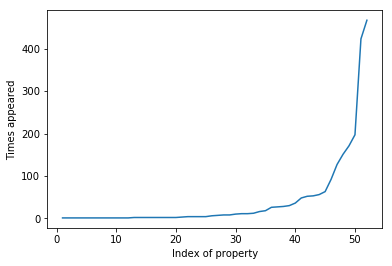

In [5]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

keyword_count = np.zeros(len(keyword_list))
keyword_index = np.zeros(len(keyword_list))
for i in range(len(keyword_list)):
    keyword_count[i] = keyword_list[i][1]
    keyword_index[i] = i + 1
    
    
keyword_count = np.sort(keyword_count)

#plt.hist(keyword_count, bins=50, normed=0)
plt.plot(keyword_index, keyword_count)
plt.xlabel("Index of property")
plt.ylabel("Times appeared")

Here we parse through the wiki files, finding the chembox properties area, then checking each line against our list of keywords that we compiled above.

In [6]:
num_nodes = len(text_nodes)
num_formula = 0
num_property = 0
num_property_units = 0

import csv
with open('properties.csv', 'w', newline='', encoding='utf-8') as csvfile:
    property_writer = csv.writer(csvfile, delimiter=',')
    for node in text_nodes:
        formula = ''
        multi_formula = ''
        formula_next_line = 0
        chembox = 0
        for line in str.splitlines(node.text):
            line = general_tag_cleanup(line)
            words = str.split(line)
            if formula_next_line == 1: # sometimes Formula appears on the next line instead of in the same line
                formula_next_line = 0
                if(words[1] != 'MolarMass'): # the line after Formula is often MolarMass, if not MolarMass, assume it is the displaced Formula
                    formula = blank_formula(line)
            if (len(words) > 1):
                for j in range(len(keyword_list)): #loop over all the property keywords that we found earlier
                    mat_property = ''
                    property_units = ''
                    multi_property = ''
                    if(words[1] == 'Formula'): # we parse the formula separatly from the properties since it has a different format and somewhat different cleanup
                        if len(words) > 3: # the line length indicates formula on this line
                            if (len(words) > 4) & (words[3][0] != '|'):                                
                                multi_formula = multi_formula_cleanup(line)
                                if len(multi_formula) == 1:
                                    formula = multi_formula[0][0] # actually only one formula

                            formula = formula_tag_cleanup(words[3])
                            formula = formula_bracket_cleanup(formula)

                            num_formula += 1

                        else: # the line length indicates formula not on this line
                            formula_next_line = 1
                            
                    elif(words[1] == keyword_list[j][0]): # check against keyword list
                        if len(words) == 5: # line length needs to be at least 5 for all info needed ('|', property, '=', value, unit)
                            if is_float(words[3]):
                                mat_property = words[3]
                                num_property += 1
                            property_units = words[4]
                            num_property_units += 1
                                
                            if (words[1] == 'MolarMass') & (property_units != 'g/mol'): # molar mass is most common property, so it gets some special cleaning
                                property_units = molar_mass_unit_cleanup(property_units)
                            else:
                                property_units = general_tag_cleanup(property_units)
                            
                        elif len(words) > 5: # if there are more than the minimum, there may be multiple properties listed for a chemical
                            multi_property = multi_property_cleanup(line)
                            if len(multi_property) == 1:
                                    if is_float(words[3]):
                                        mat_property = words[3] # record the first property in case not actually mutiple
                                        property_units = words[4] # record the first unit in case not actually mutiple

                        # here is where we determine what to write to csv
                        if (formula != '') & (mat_property != '') & (len(multi_formula) == 0): # simple case: if there is a formula anda a mat_property, write to csv 
                            property_writer.writerow([formula, keyword_list[j][0], mat_property, property_units])
                        elif (len(multi_formula) > 0): # more complicated cases: multiple formulas eg anhydrous version
                            if len(multi_formula) == len(multi_property): # equal numbers of formulas and poperties, assume orders match
                                for i in range(len(multi_formula)):
                                    property_writer.writerow([multi_formula[i][0], keyword_list[j][0], multi_property[i][0], multi_property[i][1]])
                            elif (len(multi_property) == 0) & (mat_property != ''): #multiple formulas but only one property, report first of each
                                property_writer.writerow([multi_formula[0][0], keyword_list[j][0], mat_property, property_units])
                            else: #unequal numbers of formulas and molar masses, not simple to match, don't write to csv for now
                                print('Warning: number of formulas and properties do not match:', multi_formula[0][0])
csvfile.close()
print('Done')

Done


Here we parse our csv and convert it to the pypif format

In [8]:
from pypif import pif
from pypif.obj import *

current_chemical_system = ''
chemical_system_list = []

with open('properties.csv', 'rt') as csvfile:
    property_reader = csv.reader(csvfile, delimiter=',')
    for row in property_reader:
        if (current_chemical_system != row[0]):
            #deal with the previous chemical 
            if (current_chemical_system != ''):
                chemical_system.properties = property_list
                chemical_system_list.append(chemical_system)
            #set up the new chemical
            
            current_chemical_system = row[0]
            is_new_chemical = 0
            chemical_system = ChemicalSystem()
            chemical_system.chemical_formula = row[0]
            property_list = []
        
        mat_property = Property()
        mat_property.name = row[1]
        mat_property.scalars = row[2]
        mat_property.units = row[3]
        property_list.append(mat_property)
            
#print(pif.dumps(chemical_system_list, indent=4))

And we output to a json file

In [10]:
with open('properties.json', 'w', encoding='utf-8') as outfile:
    outfile.write(pif.dumps(chemical_system_list, indent=4))